In [56]:
# ------ River imports ---------

from river import stream

# Metrics
from river.metrics import Accuracy, Precision, Recall, F1, CohenKappa, BalancedAccuracy

# Drift Detectors
from river.drift import ADWIN, KSWIN, PageHinkley, DriftRetrainingClassifier
from river.drift.binary import *

# Classifiers
from river.linear_model import LogisticRegression
from river.forest import ARFClassifier
from river.tree import HoeffdingTreeClassifier, ExtremelyFastDecisionTreeClassifier

In [57]:
# ------ Sk-learn imports -------------

# sklearn classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Sklearn Metric
from sklearn.metrics import cohen_kappa_score, accuracy_score, f1_score

# Others
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [58]:
# ------ Basic python lib imports ----------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import mplcursors
from collections import deque
import warnings
import math

warnings.filterwarnings("ignore")

%matplotlib inline
mpld3.enable_notebook()

In [59]:
# ------ Get "cfpdss" data --------------------------
df_cfpdss = pd.read_csv(
    "C:/Users/HP/Desktop/github-aditya0by0/stream-viz/data/cfpdss.csv"
)
df_cfpdss.head()

,c5,c6,c7,c8,c9,n0,n1,n2,n3,n4,class
0,a,a,b,a,a,0.448573,1.212644,2.555515,0.242702,0.697604,A
1,a,a,a,b,b,1.902515,-0.467349,-0.744523,-0.017156,-0.380288,A
2,a,a,a,b,b,0.825045,1.002267,1.972207,-0.790095,0.233456,B
3,a,a,a,b,b,-0.124974,0.902601,1.696092,-0.320182,0.243261,A
4,b,a,a,b,a,-1.259765,0.793134,1.547527,-2.132172,-0.788367,B


In [60]:
# ------ Data pre-processing --------------
X_df = df_cfpdss.drop(columns="class")

# Separating categorical and non-categorical columns
categorical_columns = X_df.select_dtypes(include=["object"]).columns.tolist()
X_df_categorical = X_df[categorical_columns]
non_cat_columns = [col for col in X_df.columns if col not in categorical_columns]
X_df_non_categorical = X_df[non_cat_columns]

# One hot encoding - Categorical data
encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
one_hot_encoded = encoder.fit_transform(X_df_categorical)
columns = encoder.get_feature_names_out()
X_df_cat_one_hot = pd.DataFrame(one_hot_encoded, columns=columns)

# Feature scaling numerical data/non-categorical data
scaler = MinMaxScaler()
X_non_cat_df = pd.DataFrame(
    scaler.fit_transform(X_df_non_categorical), columns=scaler.get_feature_names_out()
)

# Concatenate categorical and non-categorical data
X_df_encoded = pd.concat(
    [
        X_df_cat_one_hot,
        X_non_cat_df,
    ],
    axis=1,
)

# Encoding the target variable
y_df = df_cfpdss[["class"]]
y_encoder = OneHotEncoder(sparse_output=False, drop="if_binary", dtype=np.int32)
y_one_hot = y_encoder.fit_transform(y_df)
y_encoded = pd.Series(y_one_hot.ravel())

In [61]:
from MDDM import MDDM_A

In [62]:
def detect_concept_drift_using_MDDM(model, X_df, y_df, metric_func, window_size=100):
    timepoint = 0
    metric_score_list = []  # Record the real-time metric
    concept_drifts_timepoints = []
    my_model = model

    window_y = deque(maxlen=window_size)
    MDDM_A_drift_detector = MDDM_A(sliding_win_size=window_size, confidence=0.001)

    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        if y_pred is None:
            y_pred = 0
        my_model.learn_one(xi, yi)

        window_y.append((yi, y_pred))
        y_i_list, y_pred_list = zip(*window_y)
        windowed_metric_val = (
            metric_func(np.array(y_i_list), np.array(y_pred_list)) * 100
        )

        metric_score_list.append(windowed_metric_val)

        MDDM_A_drift_detector.input(int(y_pred == yi))
        if MDDM_A_drift_detector.is_change_detected:
            concept_drifts_timepoints.append(timepoint)
            my_model = my_model.clone()

        # Update the window with new prediction and get the current metric value of the window
        # window_y.append((yi, y_pred))
        # y_i_list, y_pred_list = zip(*window_y)
        # windowed_metric_val = metric_func(np.array(y_i_list), np.array(y_pred_list)) * 100

        # Recalculate the metric using only the values within the window
        # if len(window_y) == window_size:

        #     my_drift_detector.update(windowed_metric_val)

        #     if my_drift_detector.drift_detected:
        #         concept_drifts_timepoints.append(timepoint)
        #         my_model = my_model.clone()  # Clone the model upon drift detection
        #         window_y.clear()  # Clear window on drift detection

        # metric_score_list.append(windowed_metric_val)

        timepoint += 1
    print(f"no of concept drifts {len(concept_drifts_timepoints)}")
    print(f"Time points for concept drift {concept_drifts_timepoints}")
    return concept_drifts_timepoints, metric_score_list

In [63]:
# ------ Function to plot concept drift -------------
def plot_concept_drift(
    concept_drifts_timepoints,
    metric_score_list,
    name: "Model Name + Drift Detector + Metric" = "None",
):
    plt.rcParams.update({"font.size": 15})
    plt.figure(1, figsize=(10, 6))
    sns.set_style("darkgrid")
    plt.clf()
    plt.plot(
        list(range(len(metric_score_list))),
        metric_score_list,
        "-b",
        label="Avg Metric Score: %.2f%%" % (metric_score_list[-1]),
    )

    plt.legend(loc="best")
    plt.title(name + " on cfpdss dataset", fontsize=15)
    plt.xlabel("Timepoint")
    plt.ylabel("Metric Score")
    plt.xticks(np.arange(0, 13000, 1000))

    # Plot concept drift with vertical lines
    for i in range(len(concept_drifts_timepoints)):
        # plt.text(self.concept_drifts_timepoints[i] - 500, 100.8, 'Drift ' + str(i), c="red", fontsize=25)
        plt.vlines(
            concept_drifts_timepoints[i],
            0,
            100,
            colors="red",
            linewidth=2,
            linestyles="dashed",
        )
    mplcursors.cursor(hover=True)

    plt.show()

no of concept drifts 6
Time points for concept drift [1061, 2771, 4793, 7929, 10007, 12895]


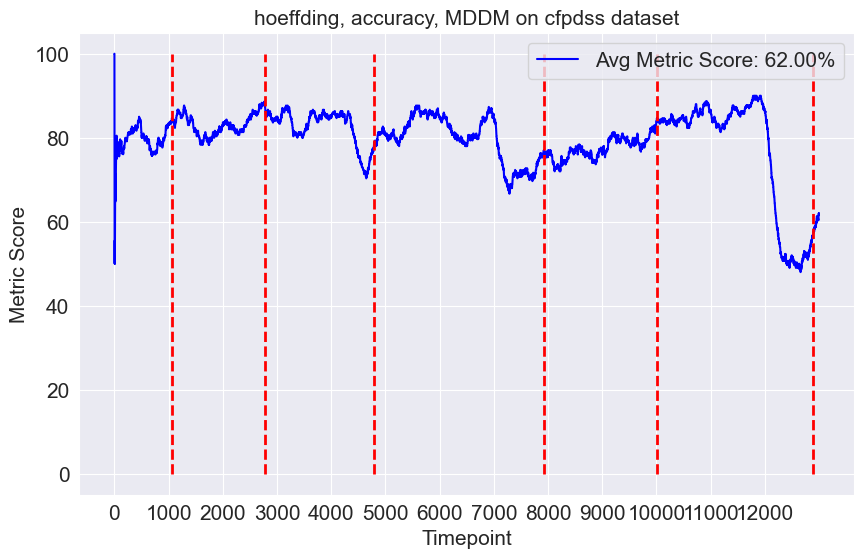

In [64]:
concept_drift_timepoints, metric_score_list = detect_concept_drift_using_MDDM(
    HoeffdingTreeClassifier(), X_df_encoded, y_encoded, accuracy_score, window_size=300
)
plot_concept_drift(
    concept_drift_timepoints,
    metric_score_list,
    "hoeffding" + ", " + "accuracy" + ", " + "MDDM",
)

In [65]:
def detect_concept_drift_using_FHDDM(model, X_df, y_df, metric_func, window_size=100):
    timepoint = 0
    metric_score_list = []  # Record the real-time metric
    concept_drifts_timepoints = []
    my_model = model

    window_y = deque(maxlen=window_size)
    drift_detector = FHDDM(sliding_window_size=window_size, confidence_level=0.001)

    # Stream data, updating the metric and checking for drifts
    for xi, yi in stream.iter_pandas(X_df, y_df):
        y_pred = my_model.predict_one(xi)
        if y_pred is None:
            y_pred = 0
        my_model.learn_one(xi, yi)

        window_y.append((yi, y_pred))
        y_i_list, y_pred_list = zip(*window_y)
        windowed_metric_val = (
            metric_func(np.array(y_i_list), np.array(y_pred_list)) * 100
        )

        metric_score_list.append(windowed_metric_val)

        drift_detector.update(int(not (y_pred == yi)))
        if drift_detector.drift_detected:
            concept_drifts_timepoints.append(timepoint)
            my_model = my_model.clone()

        # Update the window with new prediction and get the current metric value of the window
        # window_y.append((yi, y_pred))
        # y_i_list, y_pred_list = zip(*window_y)
        # windowed_metric_val = metric_func(np.array(y_i_list), np.array(y_pred_list)) * 100

        # Recalculate the metric using only the values within the window
        # if len(window_y) == window_size:

        #     my_drift_detector.update(windowed_metric_val)

        #     if my_drift_detector.drift_detected:
        #         concept_drifts_timepoints.append(timepoint)
        #         my_model = my_model.clone()  # Clone the model upon drift detection
        #         window_y.clear()  # Clear window on drift detection

        # metric_score_list.append(windowed_metric_val)

        timepoint += 1
    print(f"no of concept drifts {len(concept_drifts_timepoints)}")
    print(f"Time points for concept drift {concept_drifts_timepoints}")
    return concept_drifts_timepoints, metric_score_list

no of concept drifts 6
Time points for concept drift [1160, 2663, 4847, 7938, 9995, 12948]


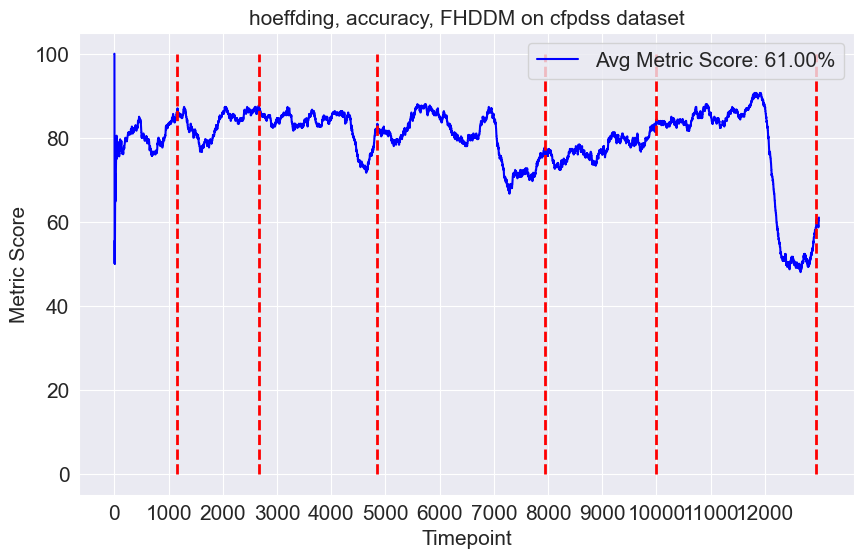

In [66]:
concept_drift_timepoints, metric_score_list = detect_concept_drift_using_FHDDM(
    HoeffdingTreeClassifier(), X_df_encoded, y_encoded, accuracy_score, window_size=300
)
plot_concept_drift(
    concept_drift_timepoints,
    metric_score_list,
    "hoeffding" + ", " + "accuracy" + ", " + "FHDDM",
)